To do list:

- aumentar o tamanho do dataset do RJ usando o scrap_v3
- usar label encoder ou onehotencoder?

In [203]:
import pandas as pd
import numpy as np
import nb_black
import os
import warnings
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

warnings.filterwarnings("ignore")

%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


## Métodos

Essa secao ficara todos os metodos e funçoes que serao utilizadas no projeto, a fim de deixar mais organizado e limpo para facilitar o entendimento

In [2]:
def print_shape_dfs(folder_path):
    files = os.listdir(folder_path)
    csv_files = [f for f in files if f.endswith(".csv")]

    for file in csv_files:
        filepath = os.path.join(folder_path, file)
        df = pd.read_csv(filepath, delimiter=";")
        print(f"{file} -> {df.shape}")

In [214]:
def concat_csv_files(folder_path):
    files = os.listdir(folder_path)
    csv_files = [f for f in files if f.endswith(".csv")]
    print_shape_dfs(folder_path)

    dfs = []
    for file in csv_files:
        filepath = os.path.join(folder_path, file)
        temp_df = pd.read_csv(filepath, delimiter=";")
        dfs.append(temp_df)

    df_kaggle = pd.read_csv("dataZAP.csv", delimiter=";")
    dfs.append(df_kaggle)

    all_columns = set().union(*[set(df.columns) for df in dfs])
    dfs = [df.reindex(columns=all_columns) for df in dfs]

    result = pd.concat(dfs, ignore_index=True)
    output_file = os.path.join("./", "dataZap_concatenated.csv")
    result.to_csv(output_file, sep=";", index=False)
    print(f"Shape do df inicial: {df_kaggle.shape}\nShape do df final: {result.shape}")

In [230]:
def check_columns(df):
    check = []
    for column in df.columns:
        types = df[column].apply(type).unique()
        if len(types) > 1:
            if pd.api.types.is_numeric_dtype(df[column]):
                try:
                    converted = pd.to_numeric(df[column], errors="raise")
                except ValueError:
                    check.append(column)
            else:
                check.append(column)

    return check

## Webscraping

### Pre-Incrementação

Essa análise abaixo foi necessária para que nosso script de webscraping tenha as mesmas colunas e formato do dataset que está no kaggle, então abaixo foi feito uma análise sobre o shape deles e também sobre quais colunas tem em um e que não tem no outro, até que se chegou no ponto final, que é quando as duas tem o mesmo shape e colunas iguais, que é o output dessa parte.

Isso impactou no código scrap_zap_v3 (nossa versão), pois tive que modificar as colunas que são filtradas e consequentemente criadas o dataframe.

dfc = dataset do kaggle

dfx = um dos datasets que o webscraping cria

In [6]:
df = pd.read_csv("dataZAP.csv", delimiter=";")
df.shape

(35772, 78)

In [7]:
df_aux = pd.read_csv(
    "webscraping-datasets/dataZap_ce_aluguel_casas_TODOS_3.csv", delimiter=";"
)
df_aux.shape

(352, 78)

In [8]:
dfc = []
for i in df.columns:
    dfc.append(i)

dfx = []
for i in df_aux.columns:
    dfx.append(i)

dfc = set(dfc)
dfx = set(dfx)

In [9]:
len(dfc.intersection(dfx))

78

In [10]:
list(dfc - dfx)

[]

In [11]:
list(dfx - dfc)

[]

Conclusao: Dessa forma final, todas os dataframes que forem realizados pelo webscraping terao as mesmas colunas e quantidades que o dataset do kaggle, facilitando a incrementacao dos dados via scraping.

### Utilização do Script de WebScraping

In [1]:
!python ./webscraping/scrap_zap_v3.py

TODOS -> TODOS -> es -> casas -> 3

Criando o arquivo dataZAP_aluguel_casas_TODOS.csv com os dados

Arquivo criado

Webscraping finalizado!


### Incrementação do Dataset

In [26]:
concat_csv_files("webscraping-datasets")

dataZap_ba_aluguel_casas_TODOS_3.csv -> (495, 78)
dataZap_ce_aluguel_casas_TODOS_3.csv -> (352, 78)
dataZap_es_aluguel_casas_TODOS_3.csv -> (106, 78)
dataZap_mg_aluguel_casas_TODOS_3.csv -> (1727, 78)
dataZap_rj_aluguel_casas_TODOS_3.csv -> (1227, 78)
dataZap_sp_aluguel_casas_TODOS_3.csv -> (8900, 78)
Shape do df inicial: (35772, 78)
Shape do df final: (48579, 78)


## Data Science

### Pre-processamento

In [658]:
df = pd.read_csv("dataZap_concatenated.csv", delimiter=";")

In [659]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48579 entries, 0 to 48578
Data columns (total 78 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   listing.address.neighborhood          48517 non-null  object 
 1   listing.mountainview                  48579 non-null  bool   
 2   listing.sauna                         48579 non-null  bool   
 3   listing.externalId                    48579 non-null  object 
 4   listing.pricingInfo.businessType      48579 non-null  object 
 5   listing.pricingInfo.monthlyCondoFee   36938 non-null  object 
 6   listing.pricingInfo.isRent            48579 non-null  bool   
 7   listing.address.level                 48579 non-null  object 
 8   listing.bathrooms                     48579 non-null  object 
 9   listing.displayAddressType            48579 non-null  object 
 10  listing.pricingInfo.isSale            48579 non-null  bool   
 11  listing.preview

In [660]:
df.describe()

,listing.pricingInfo.rentalPrice,listing.bedrooms,listing.unitsOnTheFloor,listing.unitFloor,listing.id
count,48579.000000,48579.000000,48579.00000,48579.000000,4.857900e+04
mean,100.198969,2.509665,0.24418,0.125877,2.477750e+09
std,249.669864,1.133065,1.64980,1.085948,2.175372e+08
min,1.000000,0.000000,0.00000,0.000000,4.535233e+07
25%,2.100000,1.000000,0.00000,0.000000,2.473924e+09
50%,3.750000,3.000000,0.00000,0.000000,2.486654e+09
75%,9.000000,3.000000,0.00000,0.000000,2.547760e+09
max,999.000000,14.000000,52.00000,85.000000,2.630391e+09


In [661]:
df.head()

,listing.address.neighborhood,listing.mountainview,listing.sauna,listing.externalId,listing.pricingInfo.businessType,listing.pricingInfo.monthlyCondoFee,listing.pricingInfo.isRent,listing.address.level,listing.bathrooms,listing.displayAddressType,listing.pricingInfo.isSale,listing.preview,listing.totalAreas,listing.sportcourt,listing.address.state,listing.unitTypes,listing.address.precision,account.name,listing.pricingInfo.rentalPrice,listing.advertiserId,listing.hottub,listing.bedrooms,listing.pricingInfo.period,listing.fireplace,listing.guestpark,listing.soundproofing,listing.gym,listing.floors,listing.playground,listing.partyhall,listing.subtitle,listing.createdAt,listing.listingType,listing.unitsOnTheFloor,listing.backyard,listing.usageTypes,listing.propertyType,listing.unitSubTypes,listing.pricingInfo.businessLabel,listing.garden,listing.link,listing.address.zipCode,listing.title,listing.barbgrill,listing.address.point.lon,listing.address.street,listing.pricingInfo.salePrice,listing.acceptExchange,listing.usableAreas,listing.portal,listing.furnished,listing.pricingInfo.yearlyIptu,listing.address.confidence,listing.legacyId,listing.unitFloor,listing.address.point.source,listing.businessTypeContext,listing.description,listing.tenniscourt,listing.address.streetNumber,listing.parkingSpaces,listing.address.zone,type,listing.address.city,listing.publicationType,listing.updatedAt,listing.isInactive,listing.amenities,listing.address.point.lat,imvl_type,account.licenseNumber,listing.suites,listing.bathtub,listing.pool,listing.pricingInfo.price,listing.address.country,listing.id,listing.pricingInfo.rentalTotalPrice
0,Guarajuba Monte Gordo,False,False,CO562A,RENTAL,700.0,True,CITY,5,STREET,False,False,900.0,True,Bahia,HOME,APPROXIMATE,Hansen Imóveis Ltda,3.0,04c372ee-f00e-7e39-3d53-90cfaa1a8ab2,False,3,dia,False,False,False,False,NaN,False,True,Casa para alugar em,2022-02-22T19:17:45.103Z,USED,0,False,RESIDENTIAL,UNIT,NaN,Alugar,True,/imovel/aluguel-casa-3-quartos-mobiliado-guara...,42840492.0,Casa para aluguel frente a praia em Guarajuba ...,True,NaN,Rua Arraia,NaN,False,300,GRUPOZAP,True,NaN,VALID_STREET,NaN,0,NaN,RENTAL,Sua ampla e super ventilada cozinha americana ...,True,NaN,2.0,Bairros,superPremium,Camaçari,SUPER_PREMIUM,2023-01-12T08:50:05.990Z,False,DISABLED_ACCESS|BICYCLES_PLACE|PARKING|BARBECU...,NaN,casas,NaN,3.0,False,False,3.000,BR,2552533354,NaN
1,Nazaré,False,False,CA0218,RENTAL,NaN,True,STREET,3,NEIGHBORHOOD,False,False,183.0,False,Bahia,HOME,ROOFTOP,Adriana Silva dos Santos,3.0,01a3699f-cd61-1e5b-591e-a5b91c00fc7e,False,3,mês,False,False,False,False,NaN,False,False,Casa para alugar em,2023-04-26T00:14:08.546Z,USED,0,False,RESIDENTIAL,UNIT,NaN,Alugar,False,/imovel/aluguel-casa-3-quartos-com-cozinha-naz...,40050330.0,"Casa com 3 Dormitórios para Alugar, 183 m² por...",False,NaN,NaN,NaN,False,183,GRUPOZAP,False,161.0,VALID_STREET,NaN,0,NaN,RENTAL,CASA DUPLEX<br><br>PRIMEIRO PAVIMENTO<br><br>0...,False,NaN,0.0,Bairros,superPremium,Salvador,SUPER_PREMIUM,2023-05-05T10:02:17.022Z,False,KITCHEN|INTERCOM|SERVICE_AREA,NaN,casas,NaN,1.0,False,False,3.000,BR,2628408803,NaN
2,Pituba,False,False,741,RENTAL_SALE,NaN,True,STREET,3,ALL,True,False,1000.0,False,Bahia,HOME,GEOMETRIC_CENTER,ISLV IMÓVEIS,7.5,42074fd8-9c4d-fb59-a874-b1dcb90c6890,False,3,mês,False,False,False,False,NaN,False,False,Casa para alugar e comprar em,2023-03-04T14:04:38.655Z,USED,0,False,RESIDENTIAL,UNIT,NaN,Alugar/Comprar,False,/imovel/venda-casa-3-quartos-pituba-salvador-b...,41810680.0,Casa Ampla em Pituba - Salvador,False,-38.451315,Rua Anthenor Tupinambá,1.300.000,False,300,GRUPOZAP,False,260.0,VALID_STREET,NaN,1,GOOGLE,RENTAL,"Casa ampla , situado em uma rua residencial. p...",False,NaN,7.0,Bairros,superPremium,Salvador,SUPER_PREMIUM,2023-04-29T21:40:00.231Z,False,NaN,-12.992829,casas,14268-J-BA,2.0,False,False,7.500,BR,2616700504,NaN
3,Gleba A,False,False,JC C232C,RENTAL,NaN,True,STREET,2,ALL,False,False,NaN,False,Bahia,HOME,ROOFTOP,Paulo Miranda,1.8,b06

In [662]:
df.isna().sum()

listing.address.neighborhood               62
listing.mountainview                        0
listing.sauna                               0
listing.externalId                          0
listing.pricingInfo.businessType            0
                                        ...  
listing.pool                                0
listing.pricingInfo.price                   0
listing.address.country                     0
listing.id                                  0
listing.pricingInfo.rentalTotalPrice    11658
Length: 78, dtype: int64

#### Analisando as colunas

In [663]:
columns = [
    "listing.pricingInfo.isRent",
    "listing.pricingInfo.isSale",
    "listing.pricingInfo.price",
    "listing.pricingInfo.rentalPrice",
    "listing.pricingInfo.rentalTotalPrice",
    "listing.pricingInfo.salePrice",
]
df[columns]

,listing.pricingInfo.isRent,listing.pricingInfo.isSale,listing.pricingInfo.price,listing.pricingInfo.rentalPrice,listing.pricingInfo.rentalTotalPrice,listing.pricingInfo.salePrice
0,True,False,3.000,3.00,NaN,NaN
1,True,False,3.000,3.00,NaN,NaN
2,True,True,7.500,7.50,NaN,1.300.000
3,True,False,1.800,1.80,NaN,NaN
4,True,False,1.800,1.80,NaN,NaN
...,...,...,...,...,...,...
48574,True,False,1.8,1.80,2.720,normal
48575,True,False,1.19,1.19,1.434,normal
48576,True,False,940.0,940.00,1.054,normal
48577,True,False,1.6,1.60,2.294,normal


In [664]:
df["listing.pricingInfo.rentalTotalPrice"].isna().sum()

11658

In [665]:
df["listing.pricingInfo.price"].isna().sum()

0

In [666]:
df[(df["listing.pricingInfo.isRent"] == True)]

,listing.address.neighborhood,listing.mountainview,listing.sauna,listing.externalId,listing.pricingInfo.businessType,listing.pricingInfo.monthlyCondoFee,listing.pricingInfo.isRent,listing.address.level,listing.bathrooms,listing.displayAddressType,listing.pricingInfo.isSale,listing.preview,listing.totalAreas,listing.sportcourt,listing.address.state,listing.unitTypes,listing.address.precision,account.name,listing.pricingInfo.rentalPrice,listing.advertiserId,listing.hottub,listing.bedrooms,listing.pricingInfo.period,listing.fireplace,listing.guestpark,listing.soundproofing,listing.gym,listing.floors,listing.playground,listing.partyhall,listing.subtitle,listing.createdAt,listing.listingType,listing.unitsOnTheFloor,listing.backyard,listing.usageTypes,listing.propertyType,listing.unitSubTypes,listing.pricingInfo.businessLabel,listing.garden,listing.link,listing.address.zipCode,listing.title,listing.barbgrill,listing.address.point.lon,listing.address.street,listing.pricingInfo.salePrice,listing.acceptExchange,listing.usableAreas,listing.portal,listing.furnished,listing.pricingInfo.yearlyIptu,listing.address.confidence,listing.legacyId,listing.unitFloor,listing.address.point.source,listing.businessTypeContext,listing.description,listing.tenniscourt,listing.address.streetNumber,listing.parkingSpaces,listing.address.zone,type,listing.address.city,listing.publicationType,listing.updatedAt,listing.isInactive,listing.amenities,listing.address.point.lat,imvl_type,account.licenseNumber,listing.suites,listing.bathtub,listing.pool,listing.pricingInfo.price,listing.address.country,listing.id,listing.pricingInfo.rentalTotalPrice
0,Guarajuba Monte Gordo,False,False,CO562A,RENTAL,700.0,True,CITY,5,STREET,False,False,900.0,True,Bahia,HOME,APPROXIMATE,Hansen Imóveis Ltda,3.00,04c372ee-f00e-7e39-3d53-90cfaa1a8ab2,False,3,dia,False,False,False,False,NaN,False,True,Casa para alugar em,2022-02-22T19:17:45.103Z,USED,0,False,RESIDENTIAL,UNIT,NaN,Alugar,True,/imovel/aluguel-casa-3-quartos-mobiliado-guara...,42840492.0,Casa para aluguel frente a praia em Guarajuba ...,True,NaN,Rua Arraia,NaN,False,300,GRUPOZAP,True,NaN,VALID_STREET,NaN,0,NaN,RENTAL,Sua ampla e super ventilada cozinha americana ...,True,NaN,2.0,Bairros,superPremium,Camaçari,SUPER_PREMIUM,2023-01-12T08:50:05.990Z,False,DISABLED_ACCESS|BICYCLES_PLACE|PARKING|BARBECU...,NaN,casas,NaN,3.0,False,False,3.000,BR,2552533354,NaN
1,Nazaré,False,False,CA0218,RENTAL,NaN,True,STREET,3,NEIGHBORHOOD,False,False,183.0,False,Bahia,HOME,ROOFTOP,Adriana Silva dos Santos,3.00,01a3699f-cd61-1e5b-591e-a5b91c00fc7e,False,3,mês,False,False,False,False,NaN,False,False,Casa para alugar em,2023-04-26T00:14:08.546Z,USED,0,False,RESIDENTIAL,UNIT,NaN,Alugar,False,/imovel/aluguel-casa-3-quartos-com-cozinha-naz...,40050330.0,"Casa com 3 Dormitórios para Alugar, 183 m² por...",False,NaN,NaN,NaN,False,183,GRUPOZAP,False,161.0,VALID_STREET,NaN,0,NaN,RENTAL,CASA DUPLEX<br><br>PRIMEIRO PAVIMENTO<br><br>0...,False,NaN,0.0,Bairros,superPremium,Salvador,SUPER_PREMIUM,2023-05-05T10:02:17.022Z,False,KITCHEN|INTERCOM|SERVICE_AREA,NaN,casas,NaN,1.0,False,False,3.000,BR,2628408803,NaN
2,Pituba,False,False,741,RENTAL_SALE,NaN,True,STREET,3,ALL,True,False,1000.0,False,Bahia,HOME,GEOMETRIC_CENTER,ISLV IMÓVEIS,7.50,42074fd8-9c4d-fb59-a874-b1dcb90c6890,False,3,mês,False,False,False,False,NaN,False,False,Casa para alugar e comprar em,2023-03-04T14:04:38.655Z,USED,0,False,RESIDENTIAL,UNIT,NaN,Alugar/Comprar,False,/imovel/venda-casa-3-quartos-pituba-salvador-b...,41810680.0,Casa Ampla em Pituba - Salvador,False,-38.451315,Rua Anthenor Tupinambá,1.300.000,False,300,GRUPOZAP,False,260.0,VALID_STREET,NaN,1,GOOGLE,RENTAL,"Casa ampla , situado em uma rua residencial. p...",False,NaN,7.0,Bairros,superPremium,Salvador,SUPER_PREMIUM,2023-04-29T21:40:00.231Z,False,NaN,-12.992829,casas,14268-J-BA,2.0,False,False,7.500,BR,2616700504,NaN
3,Gleba A,False,False,JC C232C,RENTAL,NaN,True,STREET,2,ALL,False,False,NaN,False,Bahia,HOME,ROOFTOP,Paulo Miranda,1.80

In [667]:
df["listing.pricingInfo.businessType"].value_counts()

RENTAL         36185
RENTAL_SALE    11535
SALE_RENTAL      859
Name: listing.pricingInfo.businessType, dtype: int64

In [668]:
df["listing.displayAddressType"].value_counts()

ALL             28658
STREET          12306
NEIGHBORHOOD     7615
Name: listing.displayAddressType, dtype: int64

In [669]:
df["listing.isInactive"].value_counts()

False    48020
True       559
Name: listing.isInactive, dtype: int64

In [670]:
df["listing.floors"].unique()  # Valores mistos que serão tratados

array([nan, 0.0, 1.0, 3.0, 2.0, 6.0, 4.0, 22.0, 17.0, 71.0, 5.0, 32.0,
       '0.0', '1.0', '12.0', '32.0', '22.0', '10.0', '28.0', '3.0', '2.0',
       '6.0', '14.0', '71.0', 'normal', '2', '21', '10', '13', '15', '12',
       '4', '20', '6', '8', '3', '11', '28', '23', '9', '16', '14', '24',
       '30', '5', '17', '22', '27', '19', '1', '7', '35', '18', '25',
       '26', '660', '175', '31', '32', '33'], dtype=object)

In [671]:
df["listing.totalAreas"].unique()  # Valores mistos que serão tratados

array([900.0, 183.0, 1000.0, ..., '1778', '3600', '1108'], dtype=object)

In [672]:
# Tirando as colunas que nao importam para nossa analise

columns = [
    "listing.address.streetNumber",
    "Page",
    "account.legacyVivarealId",
    "account.legacyZapId",
    "listing.address.geoJson",
    "account.licenseNumber",
    "listing.address.ibgeCityId",
    "listing.id",
    "listing.legacyId",
    "listing.pricingInfo.priceVariation",
    "listing.description",
    "listing.images",
    "listing.videos",
    "listing.pricingInfo.isRent",
    "listing.pricingInfo.isSale",
    "listing.pricingInfo.price",
    "listing.pricingInfo.rentalTotalPrice",
    "listing.pricingInfo.salePrice",
    "listing.unitSubTypes",
    "listing.amenities",
    "account.logoUrl",
    "account.name",
    "link.href",
    "listing.updatedAt",
    "listing.subtitle",
    "listing.title",
    "listing.portal",
    "listing.createdAt",
    "listing.externalId",
    "listing.advertiserId",
    "listing.address.zipCode",
    "listing.address.street",
    "listing.address.point.lon",
    "listing.address.point.lat",
    "listing.address.precision",
    "listing.videoTour",
    "listing.address.point.source",
    "listing.address.country",
    "listing.address.confidence",
    "listing.publicationType",
    "listing.pricingInfo.businessType",
    "listing.address.state",
    "listing.listingType",
    "listing.link",
    "listing.propertyType",
    "listing.pricingInfo.businessLabel",
    "listing.isInactive",
]

lista_columns = []
for df_columns in df.columns:
    lista_columns.append(df_columns)

for column in columns:
    if column in lista_columns:
        df.drop(columns=column, axis=1, inplace=True)

In [673]:
df.shape

(48579, 42)

#### Limitando a regiao de interesse

Consideramos que a regiao importa para o calculo do modelo de previsao. Entao para isso, iremos fazer um filtro para que a nossa previsao seja mais fidedigna possivel com os valores apresentados. Dessa forma, vamos fazer a analise do preço de aluguel para o estado do Rio de Janeiro

In [674]:
pd.options.display.max_columns = 99
column_filter = df["listing.address.city"] == "Rio de Janeiro"
df = df[column_filter]

In [675]:
df.isna().sum()

listing.address.neighborhood             0
listing.mountainview                     0
listing.sauna                            0
listing.pricingInfo.monthlyCondoFee    326
listing.address.level                    0
listing.bathrooms                        0
listing.displayAddressType               0
listing.preview                          0
listing.totalAreas                      40
listing.sportcourt                       0
listing.unitTypes                        0
listing.pricingInfo.rentalPrice          0
listing.hottub                           0
listing.bedrooms                         0
listing.pricingInfo.period               0
listing.fireplace                        0
listing.guestpark                        0
listing.soundproofing                    0
listing.gym                              0
listing.floors                         378
listing.playground                       0
listing.partyhall                        0
listing.unitsOnTheFloor                  0
listing.bac

In [676]:
df.head(1)

,listing.address.neighborhood,listing.mountainview,listing.sauna,listing.pricingInfo.monthlyCondoFee,listing.address.level,listing.bathrooms,listing.displayAddressType,listing.preview,listing.totalAreas,listing.sportcourt,listing.unitTypes,listing.pricingInfo.rentalPrice,listing.hottub,listing.bedrooms,listing.pricingInfo.period,listing.fireplace,listing.guestpark,listing.soundproofing,listing.gym,listing.floors,listing.playground,listing.partyhall,listing.unitsOnTheFloor,listing.backyard,listing.usageTypes,listing.garden,listing.barbgrill,listing.acceptExchange,listing.usableAreas,listing.furnished,listing.pricingInfo.yearlyIptu,listing.unitFloor,listing.businessTypeContext,listing.tenniscourt,listing.parkingSpaces,listing.address.zone,type,listing.address.city,imvl_type,listing.suites,listing.bathtub,listing.pool
2689,Abolição,False,False,NaN,STREET,1,ALL,False,NaN,False,HOME,1.35,False,3,mês,False,False,False,False,NaN,False,False,0,False,RESIDENTIAL,False,False,False,65,False,34.0,2,RENTAL,False,0.0,Zona Norte,NaN,Rio de Janeiro,casas,NaN,False,False


#### Tirando outlier do rentalprice

In [677]:
len(df["listing.pricingInfo.rentalPrice"].unique())

367

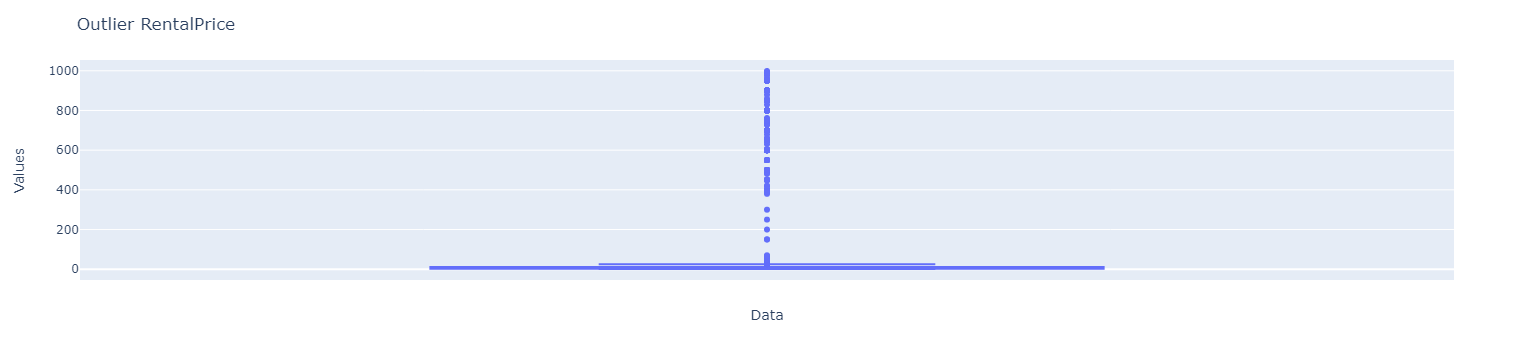

In [678]:
fig = px.box(
    df["listing.pricingInfo.rentalPrice"], y=df["listing.pricingInfo.rentalPrice"]
)
fig.update_layout(
    title="Outlier RentalPrice",
    xaxis=dict(title="Data"),
    yaxis=dict(title="Values"),
    boxmode="group",
    showlegend=False,
)
fig.show()

In [679]:
Q1 = np.percentile(df["listing.pricingInfo.rentalPrice"], 25)
Q3 = np.percentile(df["listing.pricingInfo.rentalPrice"], 75)
IQR = Q3 - Q1

threshold = 1.5
lower_limit = Q1 - threshold * IQR
upper_limit = Q3 + threshold * IQR

df = df[
    (df["listing.pricingInfo.rentalPrice"] > lower_limit)
    & (df["listing.pricingInfo.rentalPrice"] < upper_limit)
]

In [680]:
len(df["listing.pricingInfo.rentalPrice"].unique())

308

#### Completando (Fill) os valores nulos

In [681]:
# Como nao pode ter casa sem piso, sera transformado em 1 quando nulo
df["listing.floors"] = df["listing.floors"].fillna(1)

# Valor de iptu nula, deve ser sem iptu
df["listing.pricingInfo.yearlyIptu"] = df["listing.pricingInfo.yearlyIptu"].fillna(0)

# Vaga de estacionamento nula, deve ser sem vagas
df["listing.parkingSpaces"] = df["listing.parkingSpaces"].fillna(0)

# Area total nula, vamos admitir que é o mesmo tamanho da area usavel
df["listing.totalAreas"] = df["listing.totalAreas"].fillna(df["listing.usableAreas"])

In [682]:
df.isna().sum()

listing.address.neighborhood             0
listing.mountainview                     0
listing.sauna                            0
listing.pricingInfo.monthlyCondoFee    316
listing.address.level                    0
listing.bathrooms                        0
listing.displayAddressType               0
listing.preview                          0
listing.totalAreas                       0
listing.sportcourt                       0
listing.unitTypes                        0
listing.pricingInfo.rentalPrice          0
listing.hottub                           0
listing.bedrooms                         0
listing.pricingInfo.period               0
listing.fireplace                        0
listing.guestpark                        0
listing.soundproofing                    0
listing.gym                              0
listing.floors                           0
listing.playground                       0
listing.partyhall                        0
listing.unitsOnTheFloor                  0
listing.bac

In [683]:
df[df["listing.suites"].isna() == True][
    ["listing.bathrooms", "listing.bedrooms", "listing.suites"]
]

,listing.bathrooms,listing.bedrooms,listing.suites
2689,1,3,NaN
2695,1,3,NaN
2715,1,3,NaN
2740,2,3,NaN
2772,2,3,NaN
2815,2,3,NaN
2831,1,3,NaN
2885,3,3,NaN
2899,2,3,NaN
2951,2,3,NaN


In [684]:
df[["listing.bathrooms", "listing.bedrooms", "listing.suites"]]

,listing.bathrooms,listing.bedrooms,listing.suites
2689,1,3,NaN
2692,3,3,1.0
2693,1,3,1.0
2695,1,3,NaN
2701,2,3,1.0
...,...,...,...
48560,1,2,0
48566,2,3,1
48571,3,3,1
48572,2,1,0


In [685]:
df = df.dropna(subset=["listing.suites"])

In [686]:
df.isna().sum()

listing.address.neighborhood             0
listing.mountainview                     0
listing.sauna                            0
listing.pricingInfo.monthlyCondoFee    284
listing.address.level                    0
listing.bathrooms                        0
listing.displayAddressType               0
listing.preview                          0
listing.totalAreas                       0
listing.sportcourt                       0
listing.unitTypes                        0
listing.pricingInfo.rentalPrice          0
listing.hottub                           0
listing.bedrooms                         0
listing.pricingInfo.period               0
listing.fireplace                        0
listing.guestpark                        0
listing.soundproofing                    0
listing.gym                              0
listing.floors                           0
listing.playground                       0
listing.partyhall                        0
listing.unitsOnTheFloor                  0
listing.bac

In [687]:
df[["type", "listing.pricingInfo.monthlyCondoFee"]]

,type,listing.pricingInfo.monthlyCondoFee
2692,premium,NaN
2693,premium,NaN
2701,NaN,NaN
2703,NaN,NaN
2704,premium,NaN
...,...,...
48560,normal,500
48566,normal,1.296
48571,premium,968
48572,premium,480


In [688]:
df["type"].value_counts()

normal                 1920
premium                1034
superPremium            177
rankingSuperPremium       5
Name: type, dtype: int64

In [689]:
df[df.type == "premium"][["type", "listing.pricingInfo.rentalPrice"]]

,type,listing.pricingInfo.rentalPrice
2692,premium,3.9
2693,premium,1.4
2704,premium,2.3
2714,premium,1.6
2744,premium,1.5
...,...,...
48548,premium,1.4
48550,premium,1.8
48571,premium,4.7
48572,premium,1.4


In [690]:
df["type"] = df["type"].fillna("normal")

In [691]:
df["listing.pricingInfo.monthlyCondoFee"].value_counts()

normal    293
500        85
1.100      66
480        52
900        51
         ... 
1.670       1
696         1
130.0       1
651         1
3.120       1
Name: listing.pricingInfo.monthlyCondoFee, Length: 839, dtype: int64

In [692]:
df[df["listing.pricingInfo.monthlyCondoFee"] == "normal"][
    [
        "listing.pricingInfo.monthlyCondoFee",
        "listing.pricingInfo.rentalPrice",
        "listing.bedrooms",
    ]
]

,listing.pricingInfo.monthlyCondoFee,listing.pricingInfo.rentalPrice,listing.bedrooms
12842,normal,3.10,2
12900,normal,4.00,2
12902,normal,3.00,2
13285,normal,1.50,1
13694,normal,2.49,2
...,...,...,...
46889,normal,17.00,4
47383,normal,4.70,2
47401,normal,1.20,2
47408,normal,1.20,2


In [693]:
df["listing.totalAreas"] = pd.to_numeric(df["listing.totalAreas"], errors="coerce")
df["listing.totalAreas"].replace("normal", pd.NA, inplace=True)

df["listing.totalAreas"].fillna(df["listing.totalAreas"].median(), inplace=True)

In [694]:
df["listing.floors"].replace("normal", pd.NA, inplace=True)

df["listing.floors"].fillna(df["listing.floors"].median(), inplace=True)

In [695]:
df["listing.pricingInfo.yearlyIptu"] = pd.to_numeric(
    df["listing.pricingInfo.yearlyIptu"], errors="coerce"
)
df["listing.pricingInfo.yearlyIptu"].replace("normal", pd.NA, inplace=True)

df["listing.pricingInfo.yearlyIptu"].fillna(
    df["listing.pricingInfo.yearlyIptu"].median(), inplace=True
)

In [696]:
df["listing.suites"] = pd.to_numeric(df["listing.suites"], errors="coerce")
df["listing.suites"].replace("normal", pd.NA, inplace=True)

df["listing.suites"].fillna(df["listing.suites"].median(), inplace=True)

In [697]:
df["listing.parkingSpaces"] = pd.to_numeric(
    df["listing.parkingSpaces"], errors="coerce"
)
df["listing.parkingSpaces"].replace("normal", pd.NA, inplace=True)

df["listing.parkingSpaces"].fillna(df["listing.parkingSpaces"].median(), inplace=True)

In [698]:
df["listing.pricingInfo.monthlyCondoFee"].replace("normal", pd.NA, inplace=True)

df["listing.pricingInfo.monthlyCondoFee"].fillna(
    df["listing.pricingInfo.monthlyCondoFee"].median(), inplace=True
)

In [705]:
df.isna().sum()

listing.address.neighborhood           0
listing.mountainview                   0
listing.sauna                          0
listing.pricingInfo.monthlyCondoFee    0
listing.address.level                  0
listing.bathrooms                      0
listing.displayAddressType             0
listing.preview                        0
listing.totalAreas                     0
listing.sportcourt                     0
listing.unitTypes                      0
listing.pricingInfo.rentalPrice        0
listing.hottub                         0
listing.bedrooms                       0
listing.pricingInfo.period             0
listing.fireplace                      0
listing.guestpark                      0
listing.soundproofing                  0
listing.gym                            0
listing.floors                         0
listing.playground                     0
listing.partyhall                      0
listing.unitsOnTheFloor                0
listing.backyard                       0
listing.usageTyp

In [700]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3393 entries, 2692 to 48574
Data columns (total 42 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   listing.address.neighborhood         3393 non-null   object 
 1   listing.mountainview                 3393 non-null   bool   
 2   listing.sauna                        3393 non-null   bool   
 3   listing.pricingInfo.monthlyCondoFee  3393 non-null   object 
 4   listing.address.level                3393 non-null   object 
 5   listing.bathrooms                    3393 non-null   object 
 6   listing.displayAddressType           3393 non-null   object 
 7   listing.preview                      3393 non-null   bool   
 8   listing.totalAreas                   3393 non-null   float64
 9   listing.sportcourt                   3393 non-null   bool   
 10  listing.unitTypes                    3393 non-null   object 
 11  listing.pricingInfo.rental

In [701]:
df["listing.pricingInfo.monthlyCondoFee"]

2692     200.0
2693     200.0
2701     200.0
2703     200.0
2704     200.0
         ...  
48560      500
48566    1.296
48571      968
48572      480
48574      920
Name: listing.pricingInfo.monthlyCondoFee, Length: 3393, dtype: object

In [704]:
df["listing.pricingInfo.monthlyCondoFee"] = df[
    "listing.pricingInfo.monthlyCondoFee"
].astype(float)

#### Definindo a questão de quais são as colunas categoricas e numéricas

In [649]:


df["listing.pricingInfo.yearlyIptu"] = df["listing.pricingInfo.yearlyIptu"].astype(
    float
)
df["listing.pricingInfo.monthlyCondoFee"] = df[
    "listing.pricingInfo.monthlyCondoFee"
].astype(float)

In [650]:
df["listing.bedrooms"] = df["listing.bedrooms"].astype(int)
df["listing.bathrooms"] = df["listing.bathrooms"].astype(int)
df["listing.usableAreas"] = df["listing.usableAreas"].astype(int)
df["listing.suites"] = df["listing.suites"].astype(int)

In [651]:
df.to_csv("./dataZap_final.csv", sep=";", index=False)

#### Selecionar as features baseada na correlação

In [655]:
df = pd.read_csv("dataZap_final.csv", delimiter=";")

In [656]:
df.isna().sum()

listing.address.neighborhood             0
listing.mountainview                     0
listing.sauna                            0
listing.pricingInfo.monthlyCondoFee    665
listing.address.level                    0
listing.bathrooms                        0
listing.displayAddressType               0
listing.preview                          0
listing.totalAreas                       0
listing.sportcourt                       0
listing.unitTypes                        0
listing.pricingInfo.rentalPrice          0
listing.hottub                           0
listing.bedrooms                         0
listing.pricingInfo.period               0
listing.fireplace                        0
listing.guestpark                        0
listing.soundproofing                    0
listing.gym                              0
listing.floors                           0
listing.playground                       0
listing.partyhall                        0
listing.unitsOnTheFloor                  0
listing.bac

<Axes: >

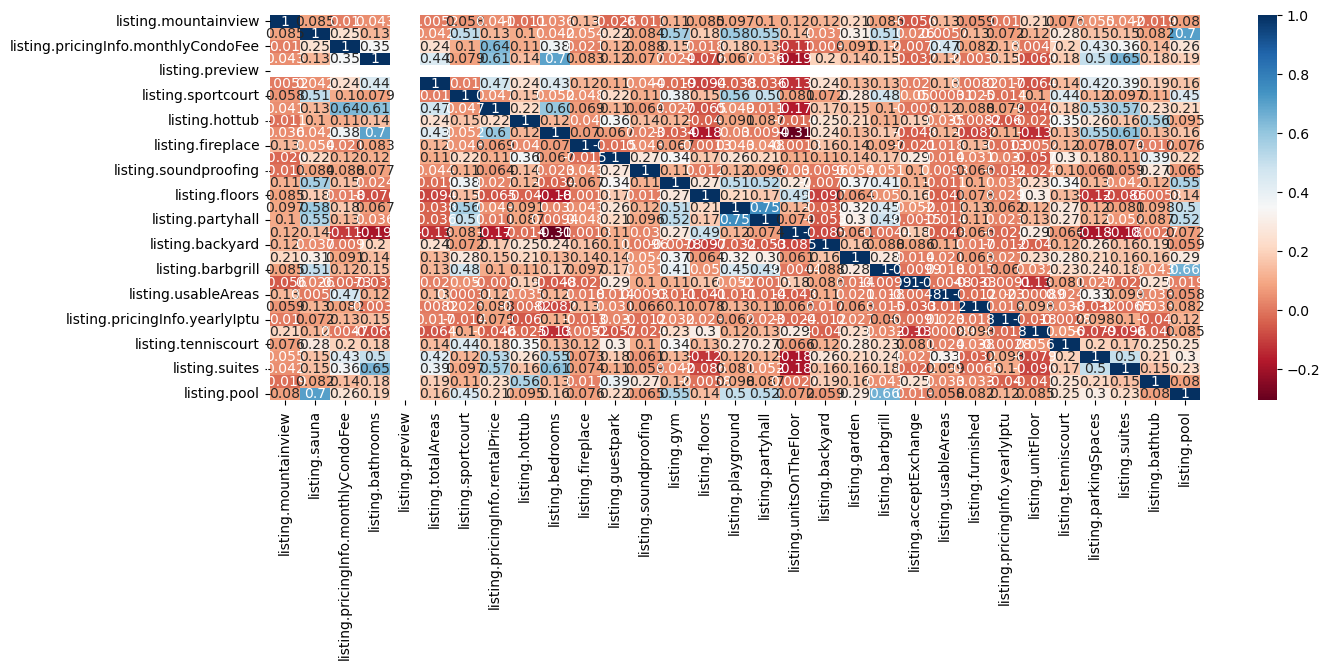

In [653]:
plt.subplots(figsize=(15, 5))
sns.heatmap(df.corr(), cmap="RdBu", cbar=True, annot=True)

Valores com uma correlação considerável:

- listing_sauna x listing pool
- listing.playground x listing.sportcourt
- listing.pricinginfo.rentalPrice x listing.bedrooms
- listing.bathtub x listing.hottub
- listing.partyhall x listing.playground
- listing.pool x listing.barbgrill

Apesar de alguns terem valores de correlação alto, não considero retirar algumas colunas pois elas podem existir mesmo que a outra não exista, então é importante deixar pois são características diferentes.

#### Categorico para numérico

In [654]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3393 entries, 0 to 3392
Data columns (total 42 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   listing.address.neighborhood         3393 non-null   object 
 1   listing.mountainview                 3393 non-null   bool   
 2   listing.sauna                        3393 non-null   bool   
 3   listing.pricingInfo.monthlyCondoFee  2728 non-null   float64
 4   listing.address.level                3393 non-null   object 
 5   listing.bathrooms                    3393 non-null   int64  
 6   listing.displayAddressType           3393 non-null   object 
 7   listing.preview                      3393 non-null   bool   
 8   listing.totalAreas                   3393 non-null   float64
 9   listing.sportcourt                   3393 non-null   bool   
 10  listing.unitTypes                    3393 non-null   object 
 11  listing.pricingInfo.rentalPric

In [600]:
cat_columns = [
    "listing.address.neighborhood",
    "listing.mountainview",
    "listing.sauna",
    "listing.address.level",
    "listing.displayAddressType",
    "listing.preview",
    "listing.sportcourt",
    "listing.unitTypes",
    "listing.hottub",
    "listing.pricingInfo.period",
    "listing.fireplace",
    "listing.guestpark",
    "listing.soundproofing",
    "listing.gym",
    "listing.playground",
    "listing.partyhall",
    "listing.backyard",
    "listing.usageTypes",
    "listing.garden",
    "listing.barbgrill",
    "listing.acceptExchange",
    "listing.furnished",
    "listing.businessTypeContext",
    "listing.tenniscourt",
    "listing.address.zone",
    "type",
    "listing.address.city",
    "imvl_type",
    "listing.bathtub",
    "listing.pool",
]

In [601]:
df[cat_columns]

,listing.address.neighborhood,listing.mountainview,listing.sauna,listing.address.level,listing.displayAddressType,listing.preview,listing.sportcourt,listing.unitTypes,listing.hottub,listing.pricingInfo.period,listing.fireplace,listing.guestpark,listing.soundproofing,listing.gym,listing.playground,listing.partyhall,listing.backyard,listing.usageTypes,listing.garden,listing.barbgrill,listing.acceptExchange,listing.furnished,listing.businessTypeContext,listing.tenniscourt,listing.address.zone,type,listing.address.city,imvl_type,listing.bathtub,listing.pool
0,Taquara,False,False,STREET,STREET,False,False,HOME,False,mês,False,False,False,False,False,False,False,RESIDENTIAL,False,True,False,False,RENTAL,False,Zona Oeste,premium,Rio de Janeiro,casas,False,False
1,Anchieta,False,False,STREET,ALL,False,False,HOME,False,mês,False,False,False,False,False,False,False,RESIDENTIAL,False,False,False,False,RENTAL,False,Zona Norte,premium,Rio de Janeiro,casas,False,False
2,Bangu,False,False,STREET,ALL,False,False,HOME,False,mês,False,False,False,False,False,False,False,RESIDENTIAL,False,False,False,False,RENTAL,False,Zona Oeste,normal,Rio de Janeiro,casas,False,False
3,Padre Miguel,False,False,STREET,NEIGHBORHOOD,False,False,HOME,False,mês,False,False,False,False,False,False,False,RESIDENTIAL,False,False,False,False,RENTAL,False,Zona Oeste,normal,Rio de Janeiro,casas,False,False
4,Campo Grande,False,False,STREET,ALL,False,False,HOME,False,mês,False,False,False,False,False,False,False,RESIDENTIAL,False,False,False,False,RENTAL,False,Zona Oeste,premium,Rio de Janeiro,casas,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3388,Jacarepaguá,False,False,STREET,ALL,False,False,APARTMENT,False,mês,False,False,False,True,False,True,False,RESIDENTIAL,False,True,False,False,RENTAL,False,Zona Oeste,normal,Rio de Janeiro,apartamentos,False,True
3389,Botafogo,False,False,STREET,ALL,False,False,APARTMENT,False,mês,False,False,False,False,True,True,False,RESIDENTIAL,False,False,False,True,RENTAL,False,Zona Sul,normal,Rio de Janeiro,apartamentos,False,False
3390,Flamengo,False,False,STREET,ALL,False,False,APARTMENT,False,mês,False,False,False,False,False,False,False,RESIDENTIAL,False,False,False,False,RENTAL,False,Zona Sul,premium,Rio de Janeiro,apartamentos,False,False
3391,Copacabana,False,False,STREET,ALL,False,False,APARTMENT,False,mês,False,False,False,False,False,False,False,RESIDENTIAL,False,False,False,False,RENTAL,False,Zona Sul,premium,Rio de Janeiro,apartamentos,False,False


In [603]:
le = LabelEncoder()

for categorical in cat_columns:
    df[categorical] = le.fit_transform(df[categorical])

In [604]:
df[cat_columns]

,listing.address.neighborhood,listing.mountainview,listing.sauna,listing.address.level,listing.displayAddressType,listing.preview,listing.sportcourt,listing.unitTypes,listing.hottub,listing.pricingInfo.period,listing.fireplace,listing.guestpark,listing.soundproofing,listing.gym,listing.playground,listing.partyhall,listing.backyard,listing.usageTypes,listing.garden,listing.barbgrill,listing.acceptExchange,listing.furnished,listing.businessTypeContext,listing.tenniscourt,listing.address.zone,type,listing.address.city,imvl_type,listing.bathtub,listing.pool
0,100,0,0,3,2,0,0,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4,1,0,1,0,0
1,4,0,0,3,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,1,0,0
2,8,0,0,3,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,1,0,0
3,71,0,0,3,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,1,0,0
4,20,0,0,3,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3388,50,0,0,3,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,4,0,0,0,0,1
3389,14,0,0,3,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,5,0,0,0,0,0
3390,37,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,1,0,0,0,0
3391,26,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,1,0,0,0,0
